In [1]:
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import re
import random

c:\Users\kairo\anaconda3\envs\cwq\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
temp = np.genfromtxt("densities.tsv", delimiter="\t", usemask=True, dtype="float16")
densities = [None for i in range(300)]
for i, d in temp:
    densities[int(i)] = d


In [10]:
def random_file():
    axes = ["A", "D", "L", "M", "P", "Pr"]
    ids = ["1","4","8","15","20","21","28","33","34","36","40","45","56","58","62","71","81","88","89","92","97","104","113","123","126","131","137","138","139","142","144","148","152","157","160","162","163","166","171","179","182","193","195","196","207","211","215","219","224","225","226","228","231","235","242"]
    bone = random.choice(ids)
    density = densities[int(bone)]
    filename = "H" + bone + "_" + random.choice(axes) + "_sp"
    print(filename)
    return filename , density

In [64]:
data = []
target = []
def populate():
    for i in range(10):
        filename, density = random_file()
        target.append(density)
        filepath = os.path.join(os.getcwd() + "\PC_LARGEST_DATASET_BIGFILES", filename)
        img = np.genfromtxt(filepath, delimiter="\t", usemask=False, dtype="float16")
        img = img[:, 1:]
        minimum = np.min(img)
        img = img - minimum 
        maximum = np.max(img)
        img = img / (maximum)
        img = img.T
        data.append(img)
        print(filename)
populate()
data = np.array(data)
print(data)

H62_L_sp
[3.02723572e-100 1.12965606e-042 3.69403225e-033 ... 5.04888974e-038
 4.02875548e-086 4.38834257e-245]
[]


In [33]:
target = np.tile(target, (100, 1)).T.reshape(len(target) * 100)

In [43]:

data = np.array(data)
#data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
dataX = data[:, 2800:]


(1000, 4700)


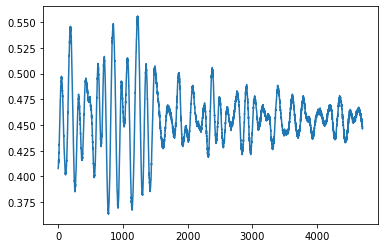

In [44]:
print(dataX.shape)
plt.plot(dataX[0])

In [23]:
# REGEX = '(?<=H)[0-9]*(?=_)'
# target = []
# imgs = []
# i = 0
# for filename in os.listdir(os.getcwd() + "\PC_LARGEST_DATASET_BIGFILES"):
    
#     #get density from list and create parallel array
#     bone_id = re.search(REGEX, filename).group(0)
#     target.append(densities[int(bone_id)])

#     #np array from current file (7500, 10, 10)
#     filepath = os.path.join(os.getcwd() + "\PC_LARGEST_DATASET_BIGFILES", filename)
#     img = np.genfromtxt(filepath, delimiter="\t", usemask=True, dtype="float16")
#     img = img[:, 1:]
#     minimum = np.min(img)
#     img = img - minimum 
#     maximum = np.max(img)
#     img = img / (maximum)
#     img = img.reshape(7500, 10, 10)
#     imgs.append(img)
#     i += 1
#     print(filename)
#     if(i > 10):
#         break
# imgs = np.array(imgs)

In [24]:
# test = img.reshape(img.shape[0], 10,10)
# plt.imshow(imgs[0][2800])
# plt.show()
# plt.imshow(imgs[1][2800])
# plt.show()
# plt.imshow(imgs[2][2800])
# plt.show()
# plt.imshow(imgs[3][2800])
# plt.show()
# plt.imshow(imgs[4][2800])
# plt.show()
# plt.imshow(imgs[5][2800])

In [25]:
# data = imgs.reshape(11,7500,100)
# print(data.shape)
# data = np.rot90(data, 1, (1,2))
# np.reshape(data.shape[0] * data.shape[1], data.shape[2])

In [45]:
print(data.shape)
print(target.shape)

(1000, 7500)
(1000,)


In [36]:
def create_dataset(data, dataY, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices((data, dataY))
    dataset = tf.data.Dataset.shuffle(dataset, buffer_size=30)
    # for x, y in dataset:
    #     print(x.numpy(), y.numpy())
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

TypeError: '_PrefetchDataset' object is not subscriptable

In [46]:

SIZE = len(dataX)
SPLIT = SIZE // 5
print(SPLIT)
x_train = np.array(dataX[:-SPLIT], dtype=float)
y_train = np.array(target[:-SPLIT], dtype=float)

x_test = np.array(dataX[-SPLIT:], dtype=float)
y_test = np.array(target[-SPLIT:], dtype=float)

shape = x_train.shape

for i, d in enumerate(x_train):
    x_train[i] = d - d.min()
    x_train[i] = x_train[i] / (d.max() - d.min())
print(x_train)


200
[[0.22998729 0.23761118 0.23761118 ... 0.42947903 0.43329098 0.44091487]
 [0.31084777 0.3053783  0.32452142 ... 0.50045579 0.49772106 0.49042844]
 [0.59464286 0.58928571 0.56785714 ... 0.65535714 0.63839286 0.64375   ]
 ...
 [0.27942354 0.29303443 0.30104083 ... 0.03522818 0.00960769 0.        ]
 [0.24       0.25103448 0.2662069  ... 0.07931034 0.05241379 0.03793103]
 [0.3821907  0.38613081 0.39873916 ... 0.04334121 0.02836879 0.        ]]


In [57]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='relu')
  ])
  return model

In [58]:
dataset = create_dataset(x_train, y_train, 10)
val_dataset = create_dataset(x_test, y_test, 10)
#print(dataset.shape)

model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.Huber(),
                metrics=['accuracy'])


[0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707  0.0949707  0.0949707  0.0949707  0.0949707  0.0949707
 0.0949707

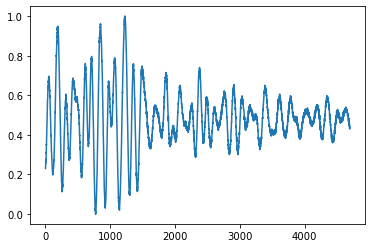

In [54]:
plt.plot(x_train[0])

In [59]:
history = model.fit(dataset, epochs = 15, verbose=2, validation_data=val_dataset)

Epoch 1/15
80/80 - 2s - loss: 0.0431 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 2s/epoch - 29ms/step
Epoch 2/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 426ms/epoch - 5ms/step
Epoch 3/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 426ms/epoch - 5ms/step
Epoch 4/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 407ms/epoch - 5ms/step
Epoch 5/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 399ms/epoch - 5ms/step
Epoch 6/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 390ms/epoch - 5ms/step
Epoch 7/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00 - 390ms/epoch - 5ms/step
Epoch 8/15
80/80 - 0s - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_